# 1. 이미지 전처리

### 라이브러리 인스톨

In [ ]:
#!pip install umap-learn hdbscan transformers

In [2]:
import torch

print("CUDA 사용 가능 여부:", torch.cuda.is_available())

CUDA 사용 가능 여부: True


### 라이브러리 임포트

In [3]:
import os
import cv2
import random
import numpy as np
import skimage
import umap
import hdbscan
import pandas as pd
import torch

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BATCH_SIZE = 8
SEED = 42

## CLIP 모델과 UMAP을 통한 이미지 클러스터링 하기

### Clip 모델을 통해 임베딩 하기

In [5]:
# https://huggingface.co/geolocal/StreetCLIP
# StreetCLIP is a robust foundation model for open-domain image geolocalization and other geographic and climate-related tasks.

clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP")
clip_model.to('cuda:1')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

In [6]:
image_paths = sorted(glob('/home/team1/restore_image/train_gt/*.png'))

In [7]:
image_features = []
for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):
    image_paths_batch = image_paths[i:i+BATCH_SIZE]
    images = [Image.open(image_path) for image_path in image_paths_batch]
    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda:1')
    with torch.no_grad():
        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()
    image_features.append(image_features_row)

100%|██████████| 3701/3701 [32:02<00:00,  1.93it/s]


In [8]:
train_embeddings = np.vstack(image_features)

In [9]:
train_embeddings = normalize(train_embeddings, norm="l2")

In [10]:
#np.save('/home/team1/mj/preproc/train_embeddings', train_embeddings)
train_embeddings = np.load('/home/team1/mj/preproc/train_embeddings.npy')

### UMAP을 통해 이미지 임베딩을 클러스터링하기

In [11]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


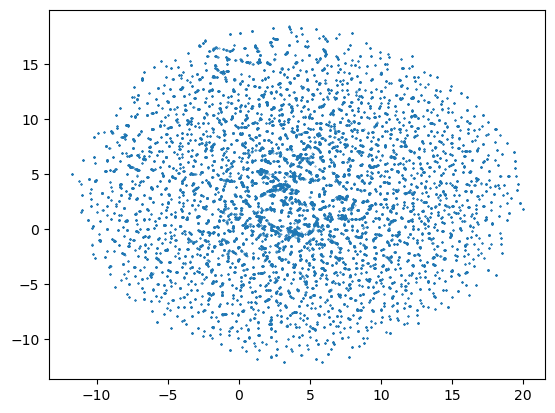

In [12]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [13]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

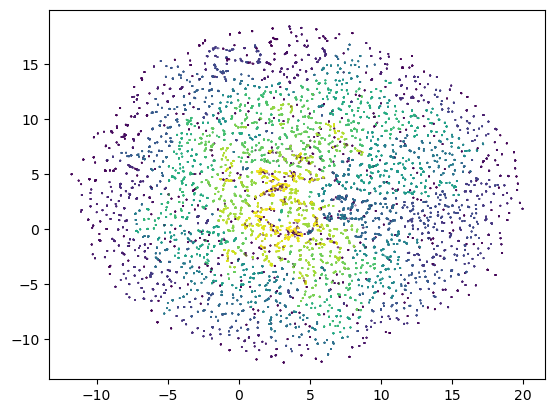

In [14]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [15]:
len(set(labels)), sum(labels==-1)

(2449, 2165)

In [16]:
counter = Counter([label for label in labels if label!=-1])

In [17]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, 10.0, 62)

## 클러스터 별 이미지 확인 및 저장하기

label is 0


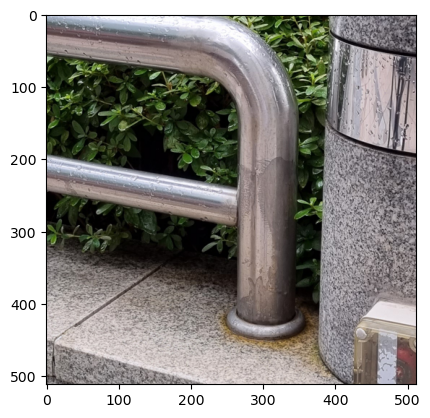

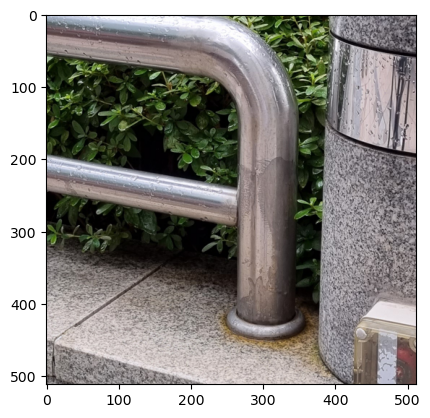

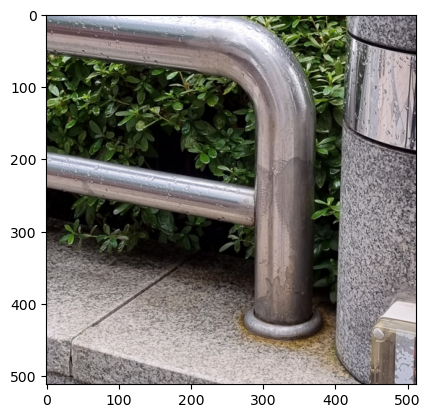

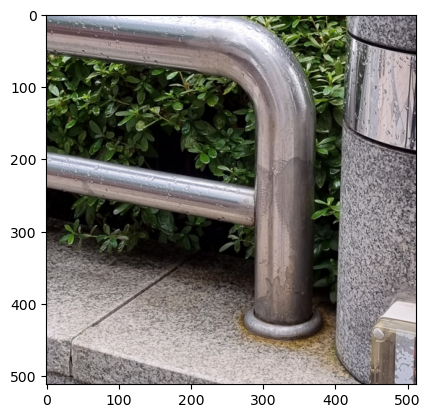

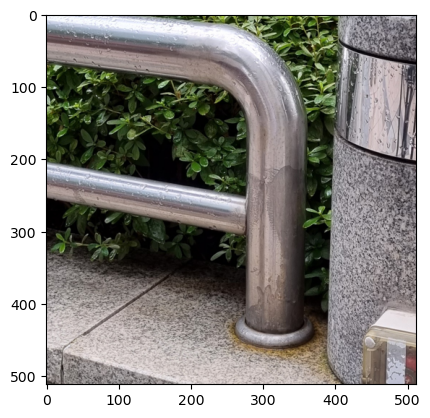

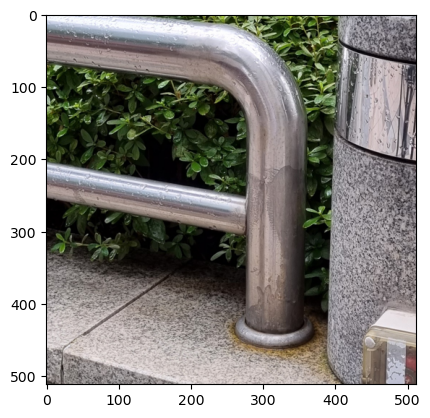

label is 1


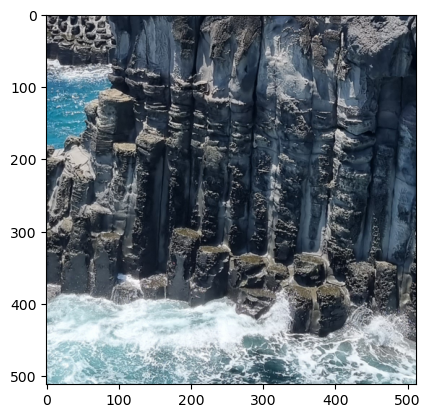

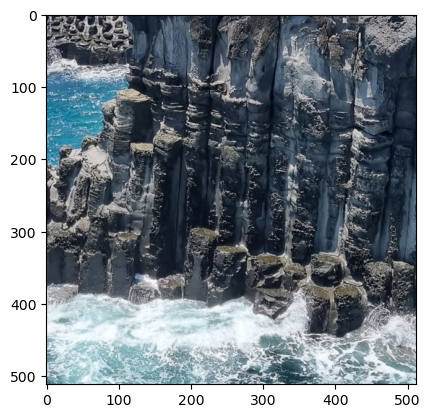

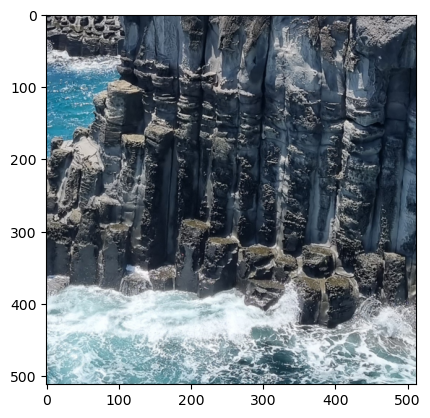

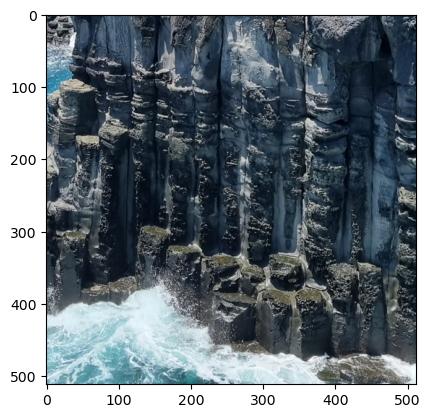

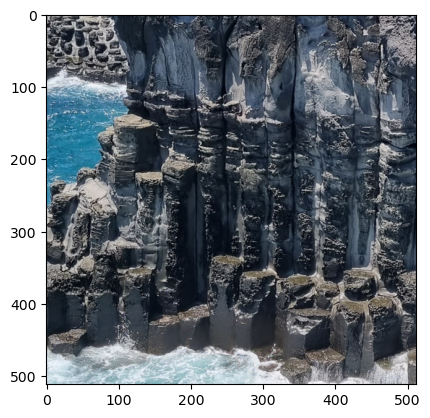

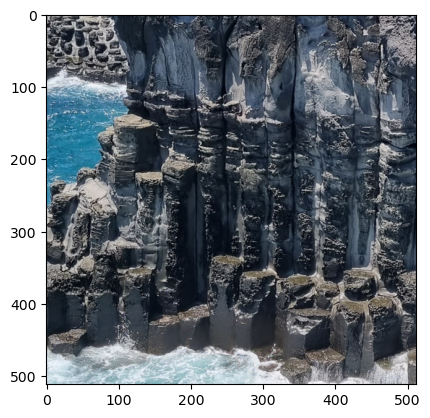

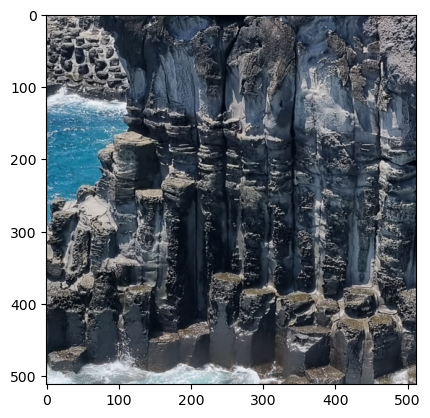

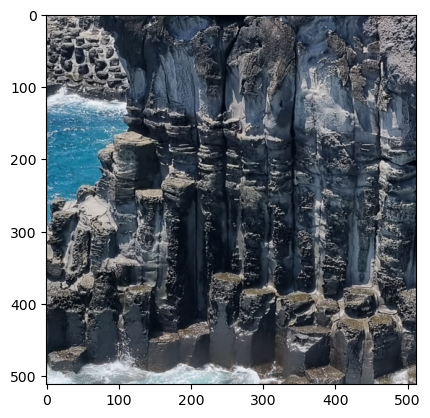

In [18]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

In [19]:
train_df = pd.DataFrame(columns=['image','label'])

In [20]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [21]:
train_df.to_csv('/home/team1/mj/preproc/train_preproc.csv', index=False)

In [22]:
test_image_paths = sorted(glob('/home/team1/restore_image/test_input/*.png'))

In [23]:
test_df = pd.DataFrame(columns=['image'])

In [24]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [25]:
test_df.to_csv('/home/team1/mj/preproc/test_preproc.csv', index=False)

# 2. 모델 학습 코드

### 라이브러리 인스톨

In [26]:
#!pip install polygenerator lightning segmentation-models-pytorch

### 라이브러리 임포트 및 필요한 함수 작성

In [27]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [28]:
torch.set_float32_matmul_precision('medium')

In [29]:
def get_input_image(image, min_polygon_bbox_size=50):
    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [30]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

### 하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [31]:
SEED=42
N_SPLIT=5
BATCH_SIZE=4
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [32]:
TRAIN_DATA_DIR='/home/team1/restore_image/train_gt'
VALID_DATA_DIR=f'/home/team1/restore_image/valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'
TEST_DATA_DIR='/home/team1/restore_image/test_input'
SUBMISSON_DATA_DIR='/home/team1/restore_image/sample_submission'
EXPERIMENT_NAME='baseline'

In [33]:
L.seed_everything(SEED)

Seed set to 42


42

In [34]:
train_df = pd.read_csv('/home/team1/mj/preproc/train_preproc.csv')
test_df = pd.read_csv('/home/team1/mj/preproc/test_preproc.csv')

In [35]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

100%|██████████| 29603/29603 [00:02<00:00, 13890.91it/s]


In [36]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [37]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [38]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

## 데이터셋 클래스 작성 및 초기화

In [39]:
class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='/home/team1/restore_image/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [40]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

## 데이터로더 작성 및 초기화

In [41]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='valid'))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='test'))

## 모델 작성 및 초기화

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # VGG16 모델의 features를 사용 (Conv4_3까지)
        self.vgg = models.vgg16(pretrained=True).features[:16]
        for param in self.vgg.parameters():
            param.requires_grad = False  # VGG는 학습하지 않도록 고정

    def forward(self, x, y):
        # ImageNet의 평균과 표준편차로 정규화
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x_norm = (x - mean) / std
        y_norm = (y - mean) / std

        # VGG를 통과한 feature map의 차이를 L1 Loss로 계산
        x_features = self.vgg(x_norm)
        y_features = self.vgg(y_norm)
        return F.l1_loss(x_features, y_features)


In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as L
from torch import nn
import segmentation_models_pytorch as smp

class LitIRModel(L.LightningModule):
    def __init__(self, models_1, models_2, image_mean=0.5, image_std=0.5):
        super().__init__()
        # nn.ModuleList로 모델 리스트를 감싸기
        self.models_1 = nn.ModuleList(models_1)  # 마스크 복원용 모델들
        self.models_2 = nn.ModuleList(models_2)  # 컬러화용 모델들
        self.image_mean = image_mean
        self.image_std = image_std

    def forward(self, images_gray_masked):
        # 마스크 복원 앙상블
        gray_outputs = [model(images_gray_masked) for model in self.models_1]
        images_gray_restored = sum(gray_outputs) / len(self.models_1)
        images_gray_restored = images_gray_restored + images_gray_masked

        # 컬러화 앙상블
        color_outputs = [model(images_gray_restored) for model in self.models_2]
        images_restored = sum(color_outputs) / len(self.models_2)

        return images_gray_restored, images_restored

    def unnormalize(self, output, round=False):
        image_restored = ((output * self.image_std + self.image_mean) * 255).clamp(0, 255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-4)

    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)

        # Gray restoration loss (L1 + MSE)
        loss_gray = F.l1_loss(images_gray, images_gray_restored) * 0.5 + F.mse_loss(images_gray, images_gray_restored) * 0.5

        # Color restoration loss (L1 + MSE)
        loss_pixel = F.l1_loss(images_gt, images_restored) * 0.5 + F.mse_loss(images_gt, images_restored) * 0.5

        # Final combined loss
        loss = loss_gray * 0.5 + loss_pixel * 0.5

        # Logging
        self.log("train_loss", loss)
        self.log("train_loss_gray", loss_gray)
        self.log("train_loss_pixel", loss_pixel)
        return loss
    
    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np
    
# 마스크 복원용 모델 앙상블 (EfficientNet + Swin Transformer)
models_1 = [
    smp.Unet(encoder_name="timm-efficientnet-b1", encoder_weights="imagenet", in_channels=1, classes=1),
    smp.Unet(encoder_name="timm-efficientnet-b4", encoder_weights="imagenet", in_channels=1, classes=1),
]

# 컬러화용 모델 앙상블 (EfficientNet + Swin Transformer)
models_2 = [
    smp.Unet(encoder_name="timm-efficientnet-b1", encoder_weights="imagenet", in_channels=1, classes=3),
    smp.Unet(encoder_name="timm-efficientnet-b4", encoder_weights="imagenet", in_channels=1, classes=3),
]    

# LitIRModel 인스턴스 생성
lit_ir_model = LitIRModel(models_1=models_1, models_2=models_2)


Epoch 0:   0%|          | 0/5488 [02:58<?, ?it/s]


## 모델 학습

In [76]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer

# 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='C:/Users/minjun/deeplearning/checkpoint',
    filename='smp-unet-efficient_ensemble-{epoch:02d}-{val_score:.4f}',
    save_top_k=1,
    save_weights_only=True,
    verbose=True
)

# 얼리 스토핑 콜백
earlystopping_callback = EarlyStopping(
    monitor="val_score",
    mode="max",
    patience=3
)

In [77]:
# Trainer 설정
trainer = Trainer(
    max_epochs=100,
    precision='bf16-mixed',
    callbacks=[checkpoint_callback, earlystopping_callback],
    detect_anomaly=False,
    accelerator="gpu",  # GPU 사용
    devices=[1]         # 0번 GPU 사용
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [78]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | models_1 | ModuleList | 29.0 M | train
1 | models_2 | ModuleList | 29.0 M | train
------------------------------------------------
58.0 M    Trainable params
0         Non-trainable params
58.0 M    Total params
231.853   Total estimated model params size (MB)
2436      Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 5488/5488 [46:08<00:00,  1.98it/s, v_num=37]     

Epoch 0, global step 5488: 'val_score' reached 0.65703 (best 0.65703), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=00-val_score=0.6570.ckpt' as top 1


Epoch 1: 100%|██████████| 5488/5488 [45:18<00:00,  2.02it/s, v_num=37]

Epoch 1, global step 10976: 'val_score' was not in top 1


Epoch 2: 100%|██████████| 5488/5488 [44:29<00:00,  2.06it/s, v_num=37]

Epoch 2, global step 16464: 'val_score' reached 0.67425 (best 0.67425), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=02-val_score=0.6743.ckpt' as top 1


Epoch 3: 100%|██████████| 5488/5488 [44:09<00:00,  2.07it/s, v_num=37]

Epoch 3, global step 21952: 'val_score' reached 0.68837 (best 0.68837), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=03-val_score=0.6884.ckpt' as top 1


Epoch 4: 100%|██████████| 5488/5488 [43:43<00:00,  2.09it/s, v_num=37]

Epoch 4, global step 27440: 'val_score' was not in top 1


Epoch 5: 100%|██████████| 5488/5488 [45:18<00:00,  2.02it/s, v_num=37]

Epoch 5, global step 32928: 'val_score' was not in top 1


Epoch 6: 100%|██████████| 5488/5488 [44:09<00:00,  2.07it/s, v_num=37]

Epoch 6, global step 38416: 'val_score' reached 0.69279 (best 0.69279), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=06-val_score=0.6928.ckpt' as top 1


Epoch 7: 100%|██████████| 5488/5488 [45:06<00:00,  2.03it/s, v_num=37]

Epoch 7, global step 43904: 'val_score' reached 0.69854 (best 0.69854), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=07-val_score=0.6985.ckpt' as top 1


Epoch 8: 100%|██████████| 5488/5488 [44:46<00:00,  2.04it/s, v_num=37]

Epoch 8, global step 49392: 'val_score' reached 0.70240 (best 0.70240), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=08-val_score=0.7024.ckpt' as top 1


Epoch 9: 100%|██████████| 5488/5488 [44:42<00:00,  2.05it/s, v_num=37]

Epoch 9, global step 54880: 'val_score' reached 0.70598 (best 0.70598), saving model to '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=09-val_score=0.7060.ckpt' as top 1


Epoch 10: 100%|██████████| 5488/5488 [44:21<00:00,  2.06it/s, v_num=37]

Epoch 10, global step 60368: 'val_score' was not in top 1


Epoch 11: 100%|██████████| 5488/5488 [44:32<00:00,  2.05it/s, v_num=37]

Epoch 11, global step 65856: 'val_score' was not in top 1


Epoch 12: 100%|██████████| 5488/5488 [39:38<00:00,  2.31it/s, v_num=37]

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Epoch 12: 100%|██████████| 5488/5488 [45:08<00:00,  2.03it/s, v_num=37]

Epoch 12, global step 71344: 'val_score' was not in top 1


Epoch 12: 100%|██████████| 5488/5488 [45:08<00:00,  2.03it/s, v_num=37]


## 모델 불러오기 및 예측

In [80]:
lit_ir_model = LitIRModel.load_from_checkpoint(
    '/home/team1/mj/C:/Users/minjun/deeplearning/checkpoint/smp-unet-efficient_ensemble-epoch=09-val_score=0.7060.ckpt',
    models_1=models_1,
    models_2=models_2,
)

In [81]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


In [82]:
predictions = np.concatenate(predictions)

In [83]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [84]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


In [85]:
# Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)